In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pickle

from mcp_us_airline.utils import airport_utils
from mcp_us_airline.utils import constants
from mcp_us_airline.utils import demand_utils
from mcp_us_airline.utils import io_utils
from mcp_us_airline.utils import population_utils
from mcp_us_airline.utils import preprocess_utils


/tmp/ipykernel_964023/1394158340.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
RAW_DIR = constants.RAW_DIR
DERIVED_DIR = constants.DERIVED_DIR
ONTIME_DIR = constants.ONTIME_DIR
DB1B_DIR = constants.DB1B_DIR
POPULATION_DIR = constants.POPULATION_DIR

In [3]:
'''
collection of parameters that generates the Supply and Demand
'''

cluster_distance = 50  # DBSCAN parameter to cluster airports (unit: km)

population_exponent1 = 1.
population_exponent2 = 1.
decay_parameter = 2.0  # decay exponent of the gravity model
distance_threshold = 300  # minimum distance that the OD demand can be defined by using the gravity model (unit: km)

delta_min = 30  # minimum connect time w.o. sharing (unit: minute)
delta_share_min = 60  # minimum connect time w. sharing (unit: minute)
share = False  # flight share/non-share

YEAR = 2023
MONTH = 4
DATE = [18]
CARRIER = "all"

ontime_df = preprocess_utils.prepare_ontime_df(year=YEAR, 
                                               month=MONTH, 
                                               date=DATE, 
                                               carrier=CARRIER, 
                                               distance_function="geodesic",
                                               arrival_time="elapsed_time",
                                               contiguous_us=True)

print(f"Number of flights within contiguous US territory: {len(ontime_df)}")
ontime_df.to_csv(os.path.join(DERIVED_DIR, f"ontime_Y{YEAR}_M{MONTH}_D{DATE[0]}_df.csv"))

/home/mk139/WorkSpace/minimum-cost-percolation-us-airline/libs/mcp_us_airline/mcp_us_airline/utils/preprocess_utils.py:68: DtypeWarning: Columns (11,13,86,93) have mixed types. Specify dtype option on import or set low_memory=False.
  ontime_df = pd.read_csv(os.path.join(ONTIME_DIR, f"On_Time_Marketing_Carrier_{year}_{month}.csv"))


total number of flights in 2023-4: 596676

total number of flights opereated by all on 2023-4-[18]: 19458



100%|██████████| 19458/19458 [00:09<00:00, 2092.34it/s]


total number of flights after adding time/distance information: 19458



/home/mk139/WorkSpace/minimum-cost-percolation-us-airline/libs/mcp_us_airline/mcp_us_airline/utils/preprocess_utils.py:44: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  master_df = pd.read_csv(f'{AIRCRAFT_DIR}/master_{year}.txt', sep=',')


number of flights with nan values: 98

number of nan values from missing tail number: 8

Number of flights within contiguous US territory: 18598


In [4]:
'''
DB1B data (supplied itineraries)
'''
db1b_file = f'DB1B_Coupon_{YEAR}_Q{int(MONTH / 12 * 4)+1}.csv'
db1b_file = os.path.join(DB1B_DIR, db1b_file)
db1b_df = pd.read_csv(db1b_file)


/home/mk139/WorkSpace/minimum-cost-percolation-us-airline/libs/mcp_us_airline/mcp_us_airline/utils/population_utils.py:36: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/nobackup/mk139/anaconda3/envs/airline-spp-application/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


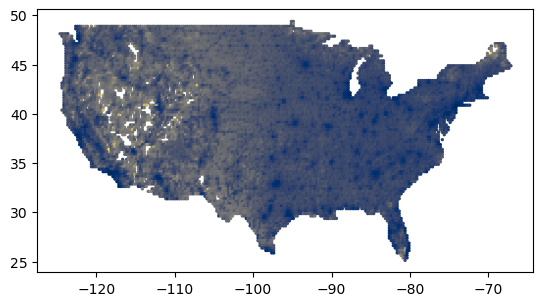

In [5]:
'''
population data
'''

population_file = "gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_15_min.asc"
population_gdf = population_utils.retrieve_us_population_gdf(
    os.path.join(POPULATION_DIR, population_file), 
    log_population=True,
    contiguous_us=True,
    post_process=True,
    )

population_gdf.plot(column='log10_population_density', cmap='cividis_r', s=2)
population_gdf.to_csv(os.path.join(DERIVED_DIR, 'population.csv'), index=False)


In [6]:
operating_coords = airport_utils.get_operating_airport_coords(ontime_df)
super_airport_dict = airport_utils.cluster_airports(cluster_distance, operating_coords)
airport_to_super_airport_mapper = airport_utils.get_airport_to_super_airport_mapper(super_airport_dict) 
super_airport_centroids = airport_utils.get_super_airport_centroids(super_airport_dict, operating_coords)
super_airport_gdf = airport_utils.get_super_airport_gdf(super_airport_centroids)

airport_utils.show_super_airports(super_airport_dict)
airport_utils.show_flights_within_super_airports(super_airport_dict, ontime_df)

pickle.dump(airport_to_super_airport_mapper, open(os.path.join(DERIVED_DIR, f'super_airport_mapper_Y{YEAR}_M{MONTH}_D{DATE[0]}.pkl'), 'wb'))
super_airport_gdf.to_csv(os.path.join(DERIVED_DIR, f'super_airport_gdf_Y{YEAR}_M{MONTH}_D{DATE[0]}.csv'), index=False)

['ASE', 'EGE']
['ATW', 'GRB']
['BRO', 'HRL']
['BUR', 'LAX', 'LGB', 'ONT', 'SNA']
['BWI', 'DCA', 'IAD']
['DAL', 'DFW']
['EWR', 'HPN', 'JFK', 'LGA']
['FLL', 'MIA']
['HHH', 'SAV']
['HOU', 'IAH']
['JST', 'LBE']
['LWS', 'PUW']
['MDW', 'ORD']
['OAK', 'SFO', 'SJC']
['ORF', 'PHF']
there is no flight within the same super airport


In [7]:
distance_df = airport_utils.get_pairwise_distance_df(super_airport_gdf, duplicate=True)
population_mapper = airport_utils.assign_population_to_super_airports(super_airport_gdf, 
                                                                      population_gdf, 
                                                                      method="nearest", 
                                                                      radius_km=None, 
                                                                      fillin="median")

pickle.dump(population_mapper, open(os.path.join(DERIVED_DIR, f'population_mapper_Y{YEAR}_M{MONTH}_D{DATE[0]}.pkl'), 'wb'))

100%|██████████| 39060/39060 [00:10<00:00, 3682.64it/s]


Shortest distance pairs between super airports:
       super_airport_1  super_airport_2  distance_km
7296                28              143    50.382487
46356              143               28    50.382487




100%|██████████| 13008/13008 [00:02<00:00, 6129.33it/s]


In [8]:
gravity_demand = demand_utils.make_gravity_model_demand(distance_df, 
                                                        population_mapper, 
                                                        minimum_distance_km=distance_threshold, 
                                                        population_exponent1=population_exponent1, 
                                                        population_exponent2=population_exponent2, 
                                                        decay_function="power", 
                                                        decay_parameter=decay_parameter,
                                                        normalize_demand=True)

gravity_demand.to_csv(os.path.join(DERIVED_DIR, f'gravity_demand_Y{YEAR}_M{MONTH}_D{DATE[0]}.csv'))

minimum demand: 0.0003595650208157498


In [9]:
OD_demand = demand_utils.create_OD_matrix_from_itineraries(db1b_df, airport_to_super_airport_mapper, aggregate=True)

collecting and sorting directional markets



100%|██████████| 11270029/11270029 [00:58<00:00, 193631.54it/s]


creating OD matrix from sorted directional markets



100%|██████████| 7616858/7616858 [00:17<00:00, 433321.18it/s]


these self-loops are discarded from the OD matrix: {}


100%|██████████| 54130/54130 [00:00<00:00, 703914.22it/s]


In [10]:
share=True
flights, origin_airport, destination_airport = preprocess_utils.group_flights_origin_destination(ontime_df)
fcn = preprocess_utils.create_flight_connection_network(flights, origin_airport, delta_min, delta_share_min, share)

fname = os.path.join(DERIVED_DIR, f'fcn_Y{YEAR}_M{MONTH}_D{DATE[0]}_coop.dat')
io_utils.write_flight_connection_network_to_file(fname, fcn)


share=False
flights, origin_airport, destination_airport = preprocess_utils.group_flights_origin_destination(ontime_df)
fcn = preprocess_utils.create_flight_connection_network(flights, origin_airport, delta_min, delta_share_min, share)

fname = os.path.join(DERIVED_DIR, f'fcn_Y{YEAR}_M{MONTH}_D{DATE[0]}_non_coop.dat')
io_utils.write_flight_connection_network_to_file(fname, fcn)

100%|██████████| 18598/18598 [00:04<00:00, 4590.26it/s]


# of total edges in FCN : 2575627


100%|██████████| 18598/18598 [00:03<00:00, 5340.10it/s]


# of total edges in FCN : 816432


In [11]:
super_flights_df = airport_utils.get_super_flight_df(flights, airport_to_super_airport_mapper, distance_df)

fname = os.path.join(DERIVED_DIR, f'list_of_flights_Y{YEAR}_M{MONTH}_D{DATE[0]}.dat')
io_utils.write_list_of_flights_to_file(fname, flights, airport_to_super_airport_mapper)

fname = os.path.join(DERIVED_DIR, f'list_of_super_flights_Y{YEAR}_M{MONTH}_D{DATE[0]}.dat')
io_utils.write_list_of_super_flights_to_file(fname, super_flights_df)

fname = os.path.join(DERIVED_DIR, f'DB1B_demand_Y{YEAR}_Q{int(MONTH / 12 * 4)+1}.dat')
io_utils.write_supplied_demand_to_file(fname, OD_demand)

fname = os.path.join(DERIVED_DIR, f'gravity_demand_pop1_{population_exponent1}_pop2_{population_exponent2}_decay_{decay_parameter}_d_{distance_threshold}.dat')
io_utils.write_gravity_demand_to_file(fname, gravity_demand)

100%|██████████| 75754/75754 [00:03<00:00, 21449.10it/s]
